In [1]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from IPython.display import display
import sys
from statistics import mean

## http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
# You can copy the function from there and save it to your computer.
sys.path.append(r'C:\Users\vhorowit\Documents')
sys.path.append(r'C:\Users\vhorowit\Documents\detect_peaks.py')
import detect_peaks
from detect_peaks import detect_peaks

#sns.set(style='ticks') # makes longer tick marks
sns.set_context('poster') # makes text larger

In [2]:
# * Windows versus mac.
#folder = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/08/09/'
folder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\08\09' 
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)  

In [3]:
# Ideally the dimensions of X and Y should be one greater than those of C; 
# if the dimensions are the same, then the last row and column of C will be ignored.

# create a listwrap that wraps around the list 
# This is what I need for pcolormesh.
def listwrap(currentlist):
    listwrap = [0] * (len(currentlist)+1)
    for i in range(len(currentlist)):
        try:
            listwrap[i+1] = ((currentlist[i]+currentlist[i+1])/2)
        except IndexError:
            pass
    topstep = listwrap[2]-listwrap[1]
    listwrap[0]=listwrap[1]-topstep
    botstep = listwrap[-2]-listwrap[-3]
    listwrap[-1]=listwrap[-2]+botstep
    return listwrap

def myheatmap(n, colorbarlabel=None, **kwargs):
    plt.pcolormesh( listwrap(n.columns),listwrap(n.index), n, **kwargs)
    plt.xlabel(n.columns.name)
    plt.ylabel(n.index.name)
    cbar = plt.colorbar(drawedges=False)
    if colorbarlabel:
        cbar.set_label(colorbarlabel)
 

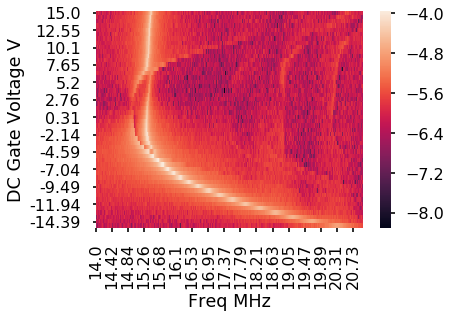

In [4]:
df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(2)
df['DC Gate Voltage V'] = df['Keithley Voltage'].round(2)
p = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False) 
sns.heatmap(p)


#plt.title(file + '\n')

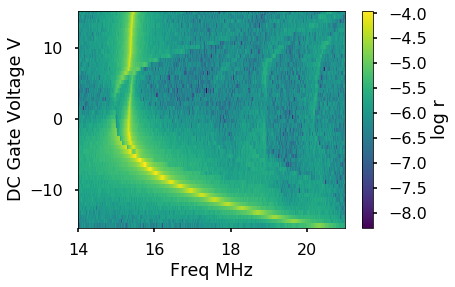

In [5]:
myheatmap(p,'log r')

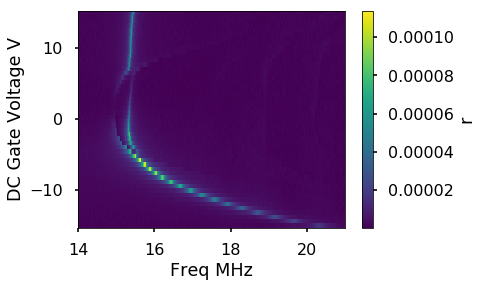

In [6]:
# This is the same heatmap as shown above except it shows r instead of log(r)

p2 = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(p2, 'r')

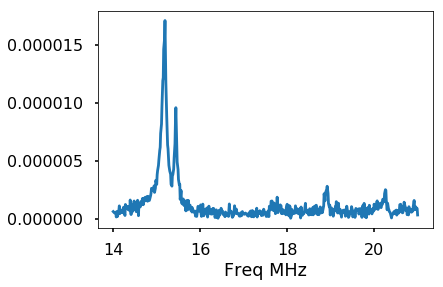

In [7]:
p2.iloc[15].plot()

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


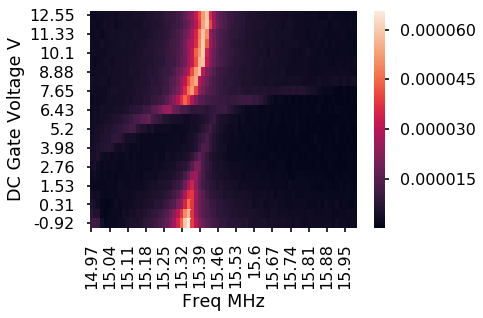

In [8]:
lf = df['Freq MHz'] > 14.95 
hf = df['Freq MHz'] < 16 
lv = df['DC Gate Voltage V'] > -1
hv = df['DC Gate Voltage V'] < 13.1
n = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
sns.heatmap(n)

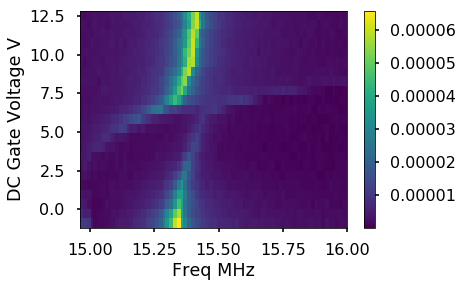

In [9]:
myheatmap(n)

In [28]:
path = os.path.join(folder,'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate115601')
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)

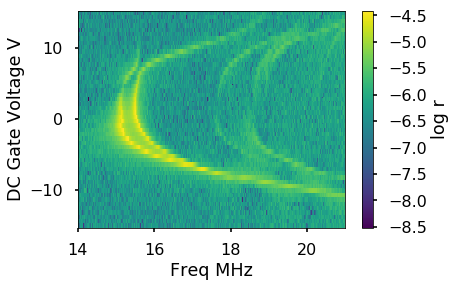

In [31]:
df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(5)
df['DC Gate Voltage V'] = df['Keithley Voltage'].round(5)
p = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False) 
myheatmap(p, 'log r')

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


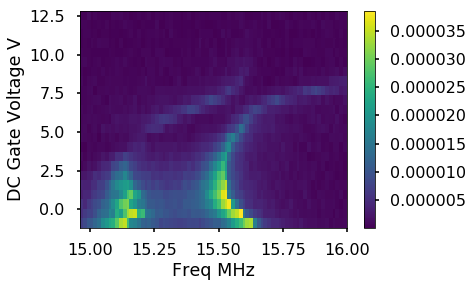

In [12]:
lf = df['Freq MHz'] > 14.95 
hf = df['Freq MHz'] < 16 
lv = df['DC Gate Voltage V'] > -1
hv = df['DC Gate Voltage V'] < 13.1
n = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
myheatmap(n)

In [33]:
path = os.path.join(folder,'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNode110245')
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#df.head()

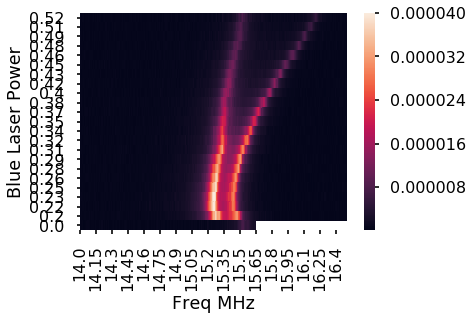

In [37]:
df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(2)
df['Blue Laser Power'] = df['DC Offset'].round(2)
p = df.pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
#p.columns_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
sns.heatmap(p, yticklabels=True)

In [35]:
p.index

Float64Index([0.52, 0.51, 0.49, 0.48, 0.46, 0.45, 0.43, 0.42,  0.4, 0.38, 0.37,
              0.35, 0.34, 0.32, 0.31, 0.29, 0.28, 0.26, 0.25, 0.23, 0.22,  0.2,
               0.0],
             dtype='float64', name='Blue Laser Power')

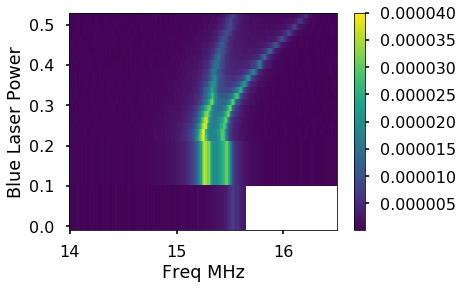

In [39]:
myheatmap(p)

In [40]:
path = os.path.join(folder,'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1094547')
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)

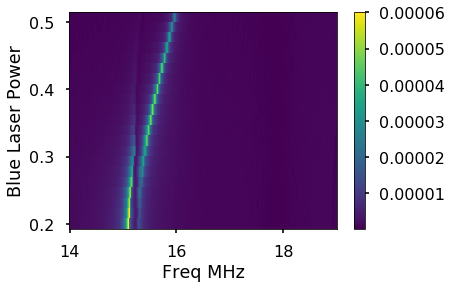

In [58]:
## warning: round(2) does not create evenly spaced frequency values.
df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)
df['Blue Laser Power'] = df['DC Offset'].round(9)
p = df.pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(p.iloc[:-1]) # cutting out last row because it is incomplete

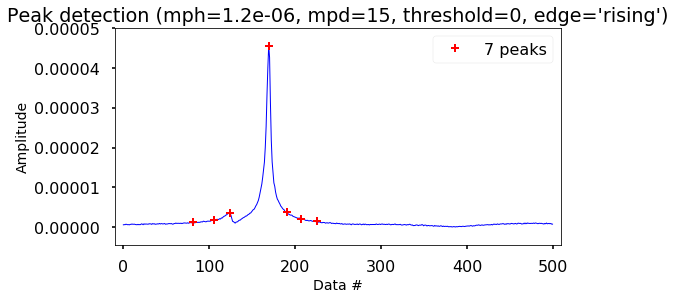

array([ 81, 105, 124, 169, 190, 207, 225], dtype=int64)

In [88]:
detect_peaks(p.iloc[6], 
             mph=1.2e-6, 
           #  threshold=1e-8,
             mpd=15,
             show=True)

0


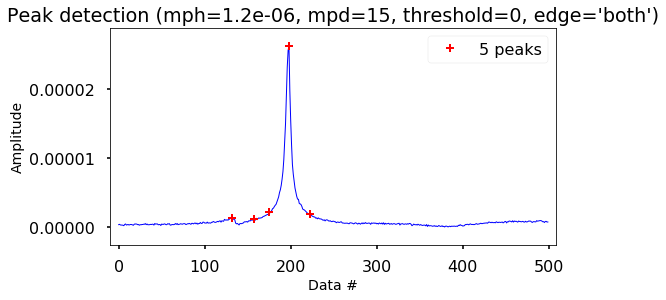

[132 157 175 198 223]
1


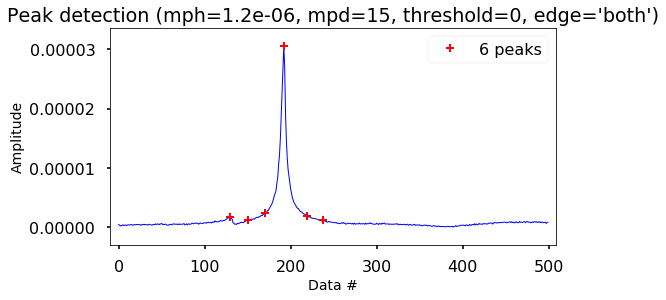

[130 150 170 192 219 237]
2


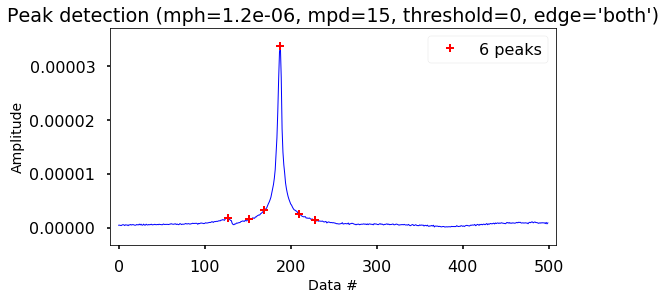

[127 151 169 188 210 228]
3


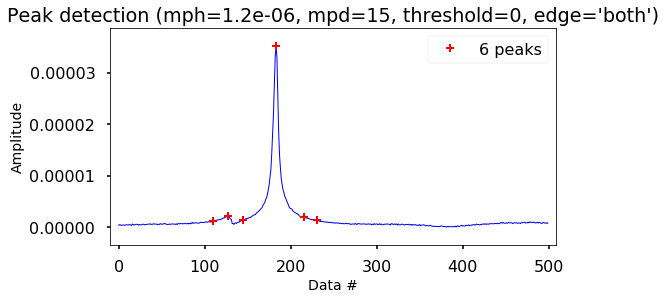

[110 127 145 183 215 231]
4


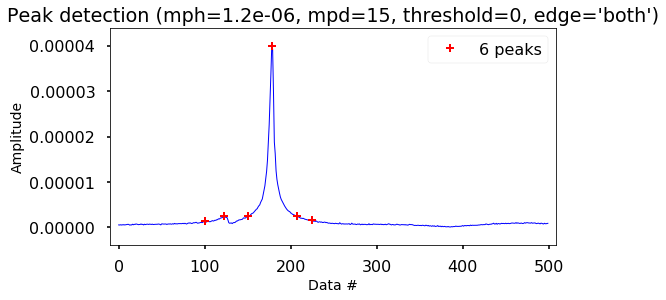

[100 123 150 178 207 225]
5


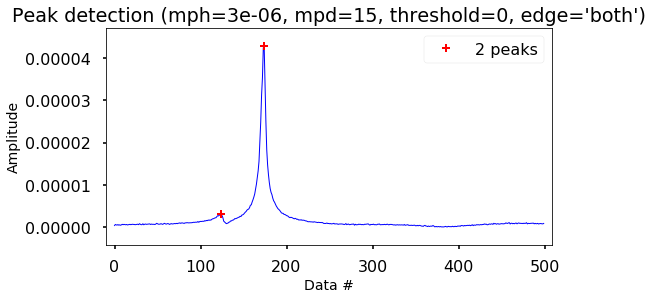

[124 174]
6


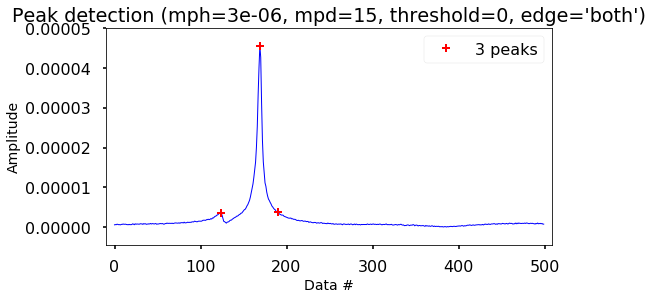

[124 169 190]
7


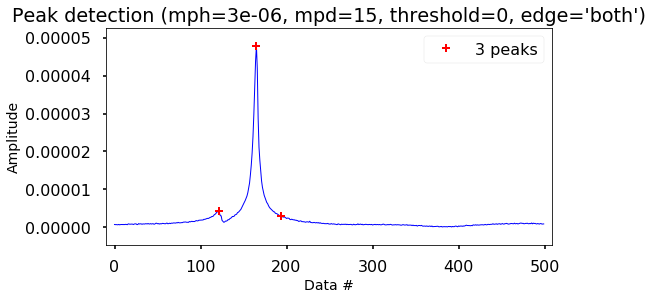

[121 165 193]
8


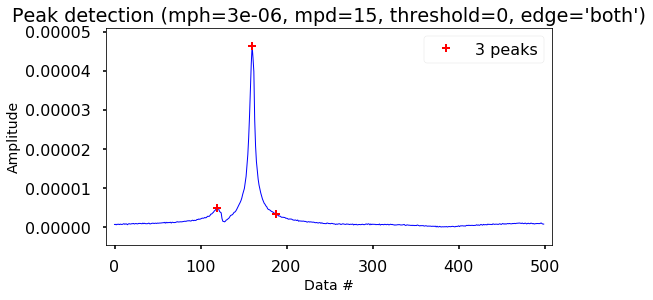

[119 160 188]
9


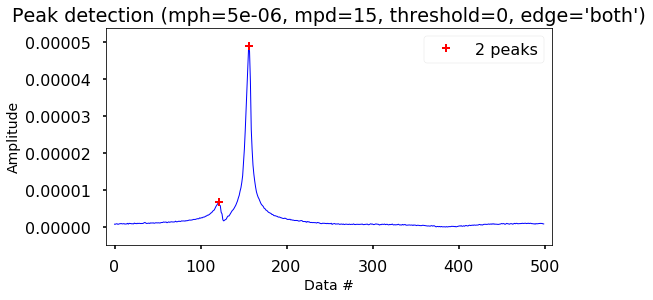

[121 156]
10


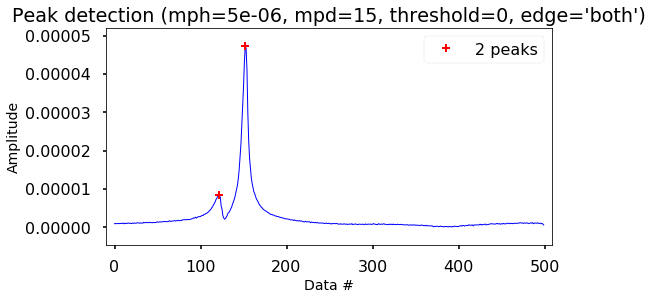

[121 152]
11


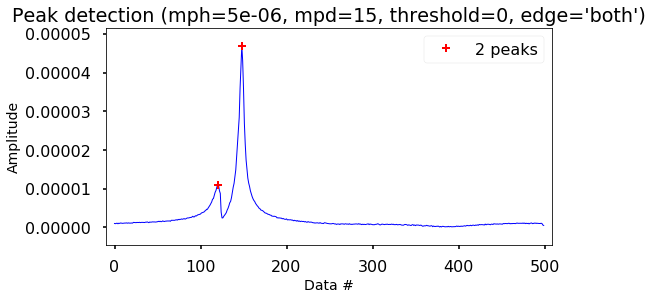

[120 148]
12


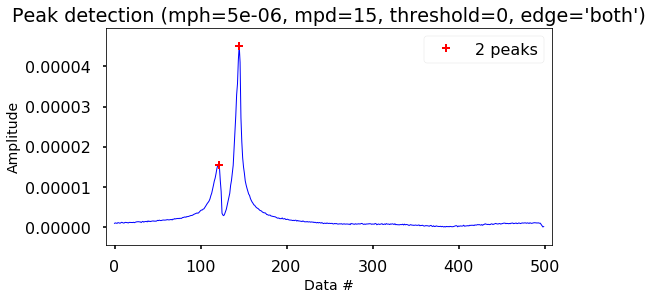

[121 145]
13


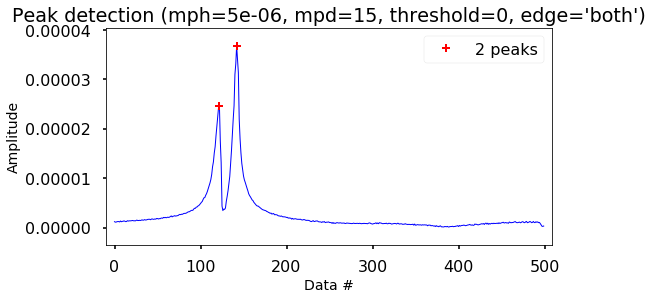

[122 142]
14


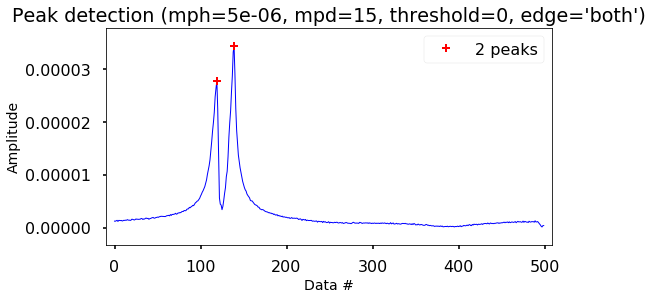

[119 139]
15


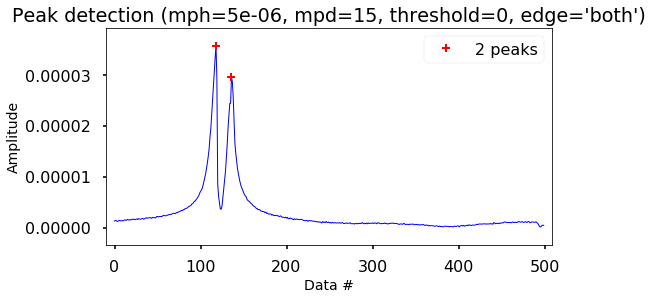

[118 136]
16


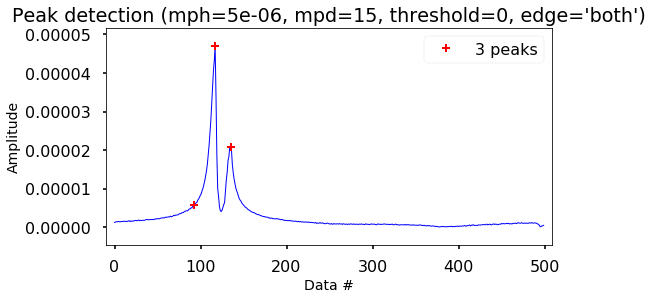

[ 92 117 135]
17


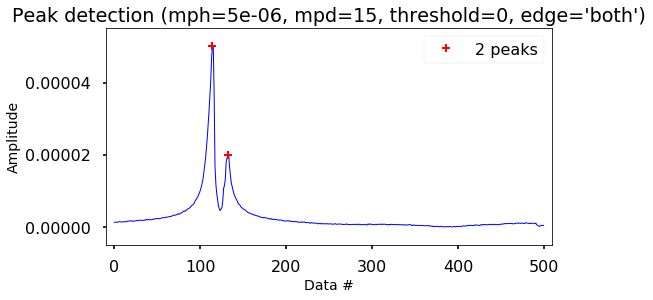

[114 132]
18


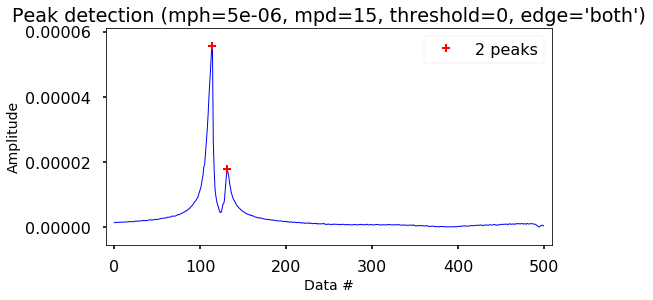

[114 131]
19


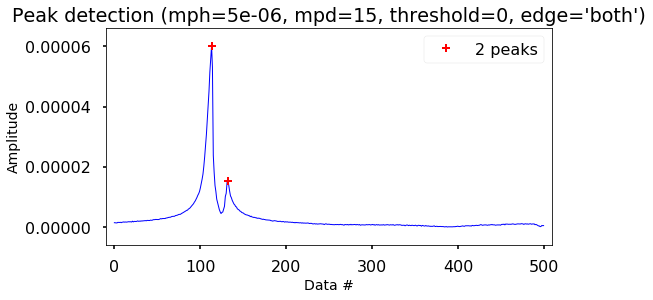

[113 132]
20


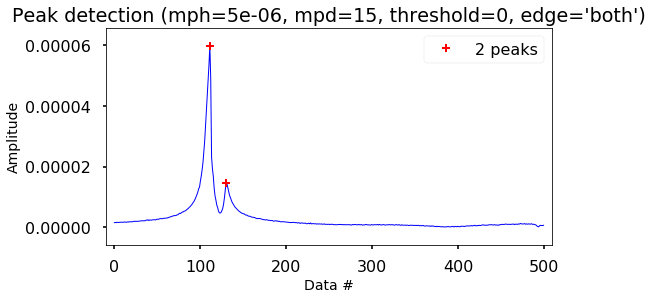

[111 130]
21


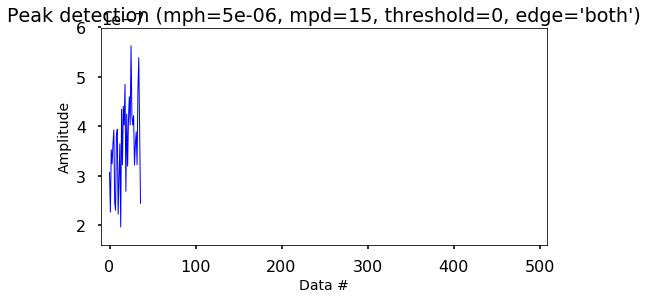

[]
[Float64Index([15.322645291, 15.573146293, 15.753507014, 15.983967936,
              16.234468938],
             dtype='float64', name='Freq MHz'), Float64Index([ 15.30260521, 15.503006012, 15.703406814, 15.923847695,
              16.194388778, 16.374749499],
             dtype='float64', name='Freq MHz'), Float64Index([ 15.27254509, 15.513026052, 15.693386774, 15.883767535,
              16.104208417, 16.284569138],
             dtype='float64', name='Freq MHz'), Float64Index([15.102204409,  15.27254509, 15.452905812, 15.833667335,
              16.154308617, 16.314629259],
             dtype='float64', name='Freq MHz'), Float64Index([15.002004008,  15.23246493, 15.503006012, 15.783567134,
              16.074148297, 16.254509018],
             dtype='float64', name='Freq MHz'), Float64Index([15.24248497, 15.743486974], dtype='float64', name='Freq MHz'), Float64Index([15.24248497, 15.693386774, 15.903807615], dtype='float64', name='Freq MHz'), Float64Index([15.21242485, 15.6533066

In [107]:
freqlistp = []
peaksintp = []

for i in range(len(p)):
    print(i)
    if i < 5:
        mph = 1.2e-6
    elif i < 9:
        mph = 3e-6
    else: 
        mph = 5e-6
    res= detect_peaks(p.iloc[i], 
             mph=mph, 
           #  threshold=1e-8,
             mpd=15,
             edge = 'both',
             show=True)
    print(res)
    freqlistp.append(p.columns[res])
    peaksintp.append(res)
    #print(peaksintp[i])
    
print(freqlistp)
print(peaksintp)

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


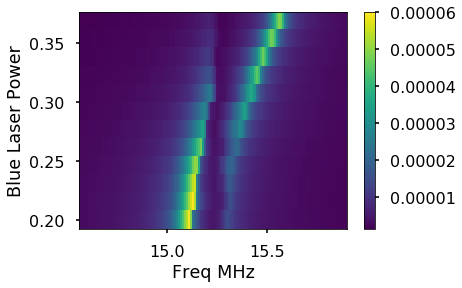

In [53]:
lf = df['Freq MHz'] > 14.57 
hf = df['Freq MHz'] < 15.9 
lv = df['Blue Laser Power'] > 0.1
hv = df['Blue Laser Power'] < 0.38
n = df[lf][hf][lv][hv].pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
myheatmap(n)

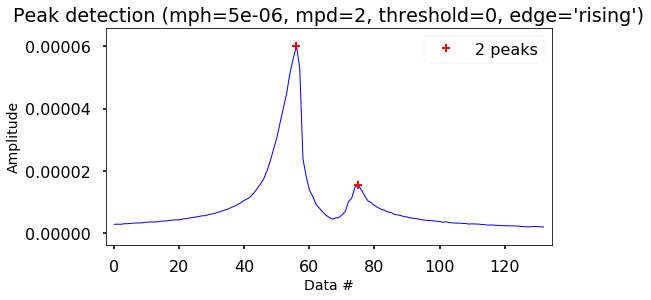

array([56, 75], dtype=int64)

In [22]:
detect_peaks(n.iloc[10], 
             mph=5e-6, 
           #  threshold=1e-8,
             mpd=2,
             show=True)

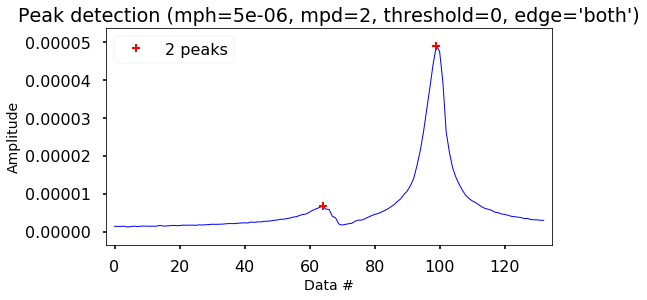

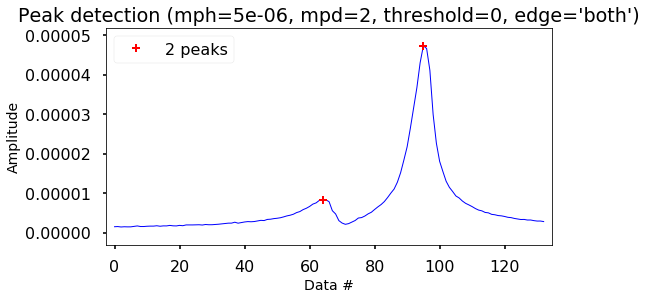

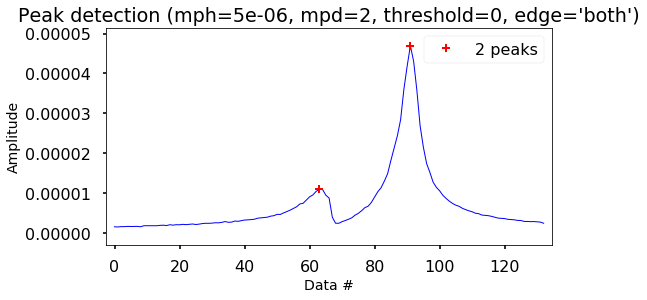

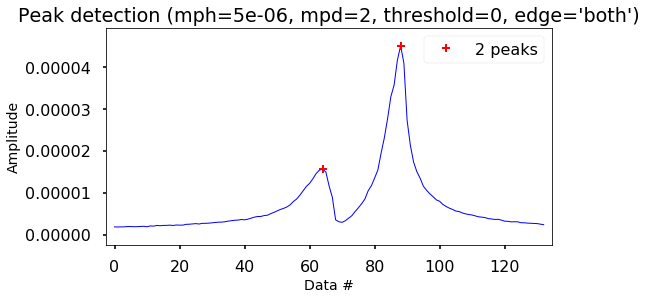

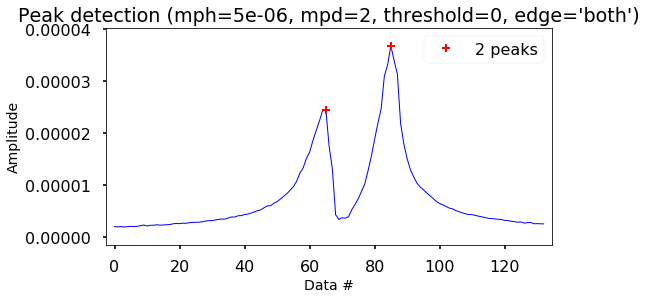

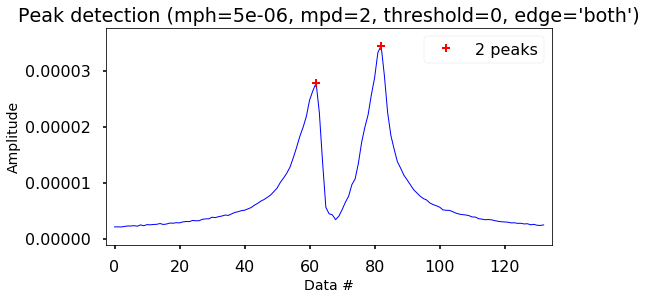

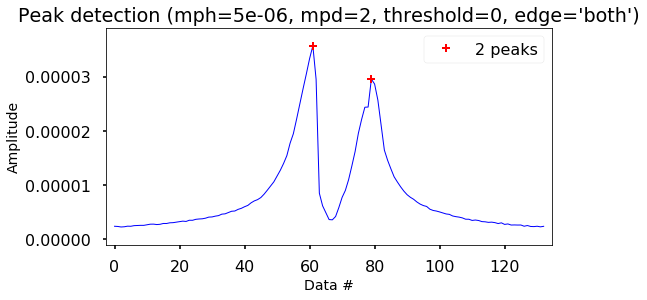

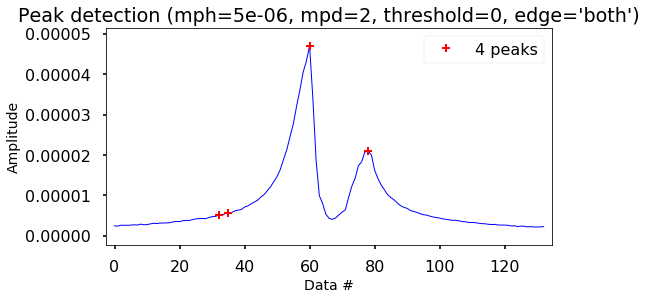

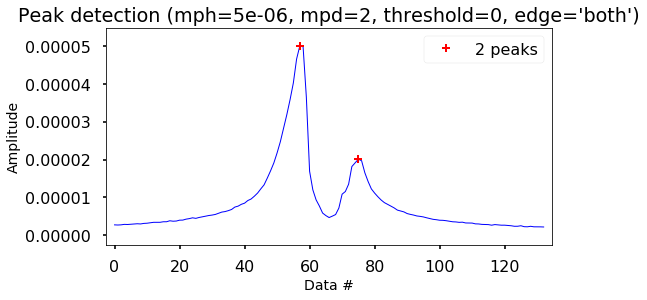

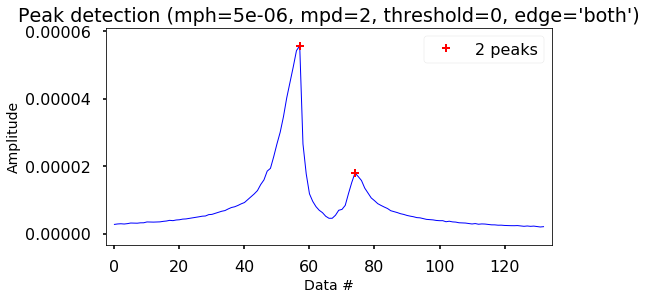

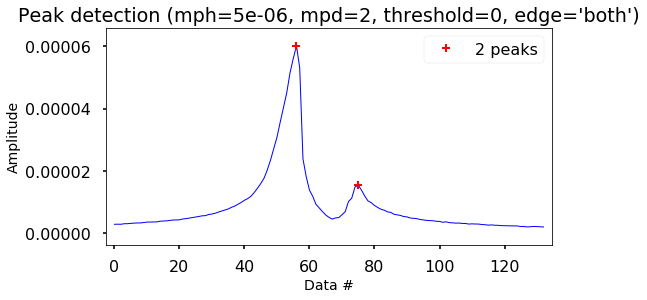

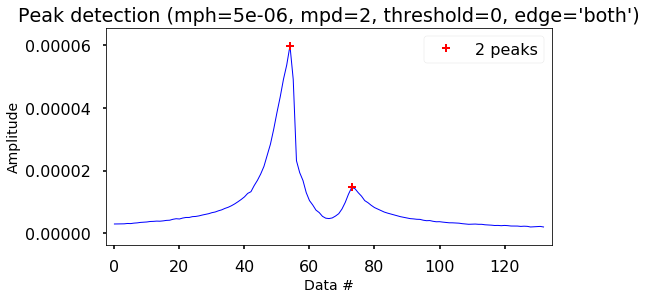

,peak1 freq [MHz],peak2 freq [MHz]
Blue Laser Power,,
0.369231,15.212425,15.563126
0.353846,15.212425,15.523046
0.338462,15.202405,15.482966
0.323077,15.212425,15.452906
0.307692,15.222445,15.422846
0.292308,15.192385,15.392786
0.276923,15.182365,15.362725
0.261538,15.172345,15.352705
0.246154,15.142285,15.322645


In [23]:
# initialize peaks list
peaksint = []
freqlist = []

for i in range(len(n)):
    res = detect_peaks(n.iloc[i], 
             mph=5e-6, 
           #  threshold=1e-8,
             mpd=2,
             edge = 'both',
             show=True)
    #print(res)
    freqlist.append(n.columns[res[-2:]])
    # shorten results to just 2 peaks
    peaksint.append(res[-2:])
    #print(peaksint[i])
    
#display(peaksint)

peakfreqs = pd.DataFrame(freqlist, index = n.index, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])
peakfreqs

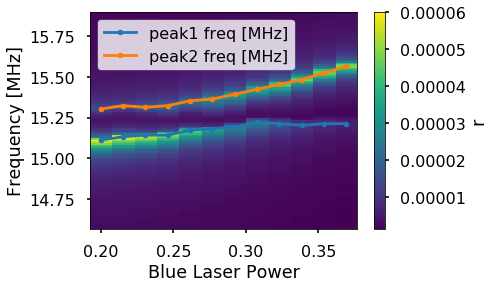

In [108]:
# To change the colors in the pcolormesh, add the pcolormesh argument: cmap = cmap
#cmap = sns.cubehelix_palette(n_colors = 1, start=0, rot=1, light=1, as_cmap=True)
#cmap = sns.cubehelix_palette( light=1, as_cmap=True)
#cmap = sns.color_palette("Grey", as_cmap=True)

plt.pcolormesh(listwrap(n.index), listwrap(n.columns), n.transpose())
ax = plt.gca()
peakfreqs.plot(ax=ax, marker = '.')
plt.ylabel("Frequency [MHz]")

cbar = plt.colorbar(drawedges=False)
cbar.set_label('r')

Text(0,0.5,'Frequency [MHz]')

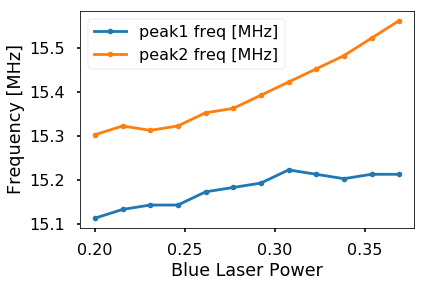

In [109]:
peakfreqs.plot(marker = '.')
plt.ylabel("Frequency [MHz]")

In [110]:
peakfreqs

,peak1 freq [MHz],peak2 freq [MHz]
Blue Laser Power,,
0.369231,15.212425,15.563126
0.353846,15.212425,15.523046
0.338462,15.202405,15.482966
0.323077,15.212425,15.452906
0.307692,15.222445,15.422846
0.292308,15.192385,15.392786
0.276923,15.182365,15.362725
0.261538,15.172345,15.352705
0.246154,15.142285,15.322645
